1. ResNet50 change only detection claassifer and train and see the results
2. ResNet50 backbone change to ResNext and train

## Download Imagenette
a subset of 10 easily classified classes from Imagenet.

In [ ]:
!wget https://s3.amazonaws.com/fast-ai-imageclas/imagenette2-320.tgz -P imagenette

--2024-08-18 17:13:26--  https://s3.amazonaws.com/fast-ai-imageclas/imagenette2-320.tgz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.204.0, 54.231.200.192, 52.216.176.237, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.204.0|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 341663724 (326M) [application/x-tar]
Saving to: ‘imagenette/imagenette2-320.tgz’

imagenette2-320.tgz 100%[===================>] 325.83M  8.52MB/s    in 48s     

2024-08-18 17:14:15 (6.72 MB/s) - ‘imagenette/imagenette2-320.tgz’ saved [341663724/341663724]



In [ ]:
!ls

imagenette  sample_data


In [ ]:
!tar zxf imagenette/imagenette2-320.tgz -C imagenette

In [ ]:
!ls imagenette/imagenette2-320

noisy_imagenette.csv  train  val


# Import necessary libraries

In [1]:
import torch
import pandas as pd
from pathlib import Path
import numpy as np
import os
from timm.data.transforms_factory import create_transform
from timm.data import create_dataset
import matplotlib.pyplot as plta
from timm.data import ImageDataset
from timm.data.loader import create_loader
import torchvision
from torch import nn
import torchvision.transforms as transforms
from torchinfo import summary
from torch.utils.data import DataLoader, Subset
from torchvision import datasets
import torch.optim as optim
import copy
import matplotlib.pyplot as plt

/home/017553289/.conda/envs/cmpe249py311/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [12]:

dataset_path = Path('/data/cmpe258-sp24/017553289/cmpe258/Assignment1/imagenette/imagenette2-320/train')
img_folder_paths = [folder for folder in dataset_path.iterdir() if folder.is_dir()]
# Display the names of the folders using a Pandas DataFrame
img_folder_names = pd.DataFrame({"Image Folder": [folder.name for folder in img_folder_paths]})
img_folder_names


,Image Folder
0,n01440764
1,n03445777
2,n03028079
3,n03417042
4,n03425413
5,n02979186
6,n03888257
7,n03394916
8,n02102040
9,n03000684


In [13]:
class_file_paths = [folder for folder in img_folder_paths]

In [14]:
class_file_paths

[PosixPath('/data/cmpe258-sp24/017553289/cmpe258/Assignment1/imagenette/imagenette2-320/train/n01440764'),
 PosixPath('/data/cmpe258-sp24/017553289/cmpe258/Assignment1/imagenette/imagenette2-320/train/n03445777'),
 PosixPath('/data/cmpe258-sp24/017553289/cmpe258/Assignment1/imagenette/imagenette2-320/train/n03028079'),
 PosixPath('/data/cmpe258-sp24/017553289/cmpe258/Assignment1/imagenette/imagenette2-320/train/n03417042'),
 PosixPath('/data/cmpe258-sp24/017553289/cmpe258/Assignment1/imagenette/imagenette2-320/train/n03425413'),
 PosixPath('/data/cmpe258-sp24/017553289/cmpe258/Assignment1/imagenette/imagenette2-320/train/n02979186'),
 PosixPath('/data/cmpe258-sp24/017553289/cmpe258/Assignment1/imagenette/imagenette2-320/train/n03888257'),
 PosixPath('/data/cmpe258-sp24/017553289/cmpe258/Assignment1/imagenette/imagenette2-320/train/n03394916'),
 PosixPath('/data/cmpe258-sp24/017553289/cmpe258/Assignment1/imagenette/imagenette2-320/train/n02102040'),
 PosixPath('/data/cmpe258-sp24/017553

### Map ImageNet WordNet IDs to label

In [15]:
# use pandas to load .txt file
df = pd.read_csv('/data/cmpe258-sp24/017553289/cmpe258/Assignment1/map_clsloc.txt', delimiter=' ', header=None, names=['WordNetID','ID', 'description'])
df


,WordNetID,ID,description
0,n02119789,1,kit_fox
1,n02100735,2,English_setter
2,n02110185,3,Siberian_husky
3,n02096294,4,Australian_terrier
4,n02102040,5,English_springer
...,...,...,...
995,n03063599,996,coffee_mug
996,n04116512,997,rubber_eraser
997,n04325704,998,stole
998,n07831146,999,carbonara


In [16]:
# use the WordNetID as the key
id_to_desc = dict(zip(df['WordNetID'], df['description']))
# id_to_desc


# Data Augmentation and create dataset 

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [18]:
transform = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225]),
        
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225]),

    ])
}

In [19]:
train_dir = '/data/cmpe258-sp24/017553289/cmpe258/Assignment1/imagenette/imagenette2-320/train'
val_dir = '/data/cmpe258-sp24/017553289/cmpe258/Assignment1/imagenette/imagenette2-320/val'

train_ds = datasets.ImageFolder(train_dir, transform=transform['train'])
val_ds = datasets.ImageFolder(val_dir, transform=transform['val'])

In [20]:
train_ds.class_to_idx

{'n01440764': 0,
 'n02102040': 1,
 'n02979186': 2,
 'n03000684': 3,
 'n03028079': 4,
 'n03394916': 5,
 'n03417042': 6,
 'n03425413': 7,
 'n03445777': 8,
 'n03888257': 9}

In [21]:
class_names = train_ds.classes
class_names

['n01440764',
 'n02102040',
 'n02979186',
 'n03000684',
 'n03028079',
 'n03394916',
 'n03417042',
 'n03425413',
 'n03445777',
 'n03888257']

In [40]:
batch_size=16
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=2)

In [13]:
# # np.random.seed(42)  # Replace 42 with any integer
# subset_size=100
# subset_indices = np.random.choice(len(train_ds), subset_size, replace=False)
# train_subset = Subset(train_ds, subset_indices)
# train_loader = DataLoader(train_subset, batch_size=4, shuffle=True, num_workers=2)


In [14]:
# # Serialize each batch
# for idx, (data, labels) in enumerate(val_loader):
#     torch.save(data, f'serialized_batches/data_batch_{idx}.pt')
#     torch.save(labels, f'serialized_batches/label_batch_{idx}.pt')

# print("Batch serialization completed.")

# Modify ResNet50 model architecture

I modified ResNet Bottleneck block with ResNext Bottleneck

In [2]:
# Loading resNeXt50 for reference
model_resNext50 = torchvision.models.get_model(name='resnext50_32x4d', weights='DEFAULT')

In [3]:
summary(model=model_resNext50, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
) 

/home/017553289/.conda/envs/cmpe249py311/lib/python3.12/site-packages/torch/cuda/__init__.py:128: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 10010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at /opt/conda/conda-bld/pytorch_1724789560443/work/c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [32, 3, 224, 224]    [32, 1000]           --                   True
├─Conv2d (conv1)                         [32, 3, 224, 224]    [32, 64, 112, 112]   9,408                True
├─BatchNorm2d (bn1)                      [32, 64, 112, 112]   [32, 64, 112, 112]   128                  True
├─ReLU (relu)                            [32, 64, 112, 112]   [32, 64, 112, 112]   --                   --
├─MaxPool2d (maxpool)                    [32, 64, 112, 112]   [32, 64, 56, 56]     --                   --
├─Sequential (layer1)                    [32, 64, 56, 56]     [32, 256, 56, 56]    --                   True
│    └─Bottleneck (0)                    [32, 64, 56, 56]     [32, 256, 56, 56]    --                   True
│    │    └─Conv2d (conv1)               [32, 64, 56, 56]     [32, 128, 56, 56]    8,192                True
│    │    └─BatchN

In [4]:
# Look into details of ResNeXt Bottleneck block to replicate
for name, child in model_resNext50.named_modules():
    if isinstance(child, torchvision.models.resnet.Bottleneck):
        print(child)

Bottleneck(
  (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (downsample): Sequential(
    (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)
Bottleneck(
  (conv1): Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), pa

In [5]:
model_resnet50 = torchvision.models.get_model(name='ResNet50', weights='DEFAULT')

In [22]:
# change detection header with corresponding nc
in_features = model_resnet50.fc.in_features
out_features = len(class_names)
model_resnet50.fc = nn.Linear(in_features=in_features, out_features=out_features, bias=True)

In [23]:
model_resnet50_modified = copy.deepcopy(model_resnet50)

In [24]:
summary(model=model_resnet50, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
) 

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [32, 3, 224, 224]    [32, 10]             --                   True
├─Conv2d (conv1)                         [32, 3, 224, 224]    [32, 64, 112, 112]   9,408                True
├─BatchNorm2d (bn1)                      [32, 64, 112, 112]   [32, 64, 112, 112]   128                  True
├─ReLU (relu)                            [32, 64, 112, 112]   [32, 64, 112, 112]   --                   --
├─MaxPool2d (maxpool)                    [32, 64, 112, 112]   [32, 64, 56, 56]     --                   --
├─Sequential (layer1)                    [32, 64, 56, 56]     [32, 256, 56, 56]    --                   True
│    └─Bottleneck (0)                    [32, 64, 56, 56]     [32, 256, 56, 56]    --                   True
│    │    └─Conv2d (conv1)               [32, 64, 56, 56]     [32, 64, 56, 56]     4,096                True
│    │    └─BatchN

In [25]:
# Create my own ResNext Bottleneck module by referencing torchvision resnext50_32x4d
class ResNeXtBottleneck(nn.Module):
    expansion = 4

    def __init__(self, c1, c2, stride=1, downsample=None, num_group=32):
        super().__init__()
        self.conv1 = nn.Conv2d(c1, c2*2, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(c2*2)
        self.conv2 = nn.Conv2d(c2*2, c2*2, kernel_size=3, stride=stride,
                               padding=1, bias=False, groups=num_group)
        self.bn2 = nn.BatchNorm2d(c2*2)
        self.conv3 = nn.Conv2d(c2*2, c2 * self.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(c2 * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)

        x = self.conv3(x)
        x = self.bn3(x)

        if self.downsample is not None:
            residual = self.downsample(residual)

        x += residual
        x = self.relu(x)

        return x

In [26]:
def replace_resnet_bottleneck(model, num_group=32):
    modules_to_replace = []
    for name, module in model.named_modules():
        for child_name, child in module.named_children():
            if isinstance(child, torchvision.models.resnet.Bottleneck):
                modules_to_replace.append((module, child_name, child))
    # print(modules_to_replace)
    
    # Step 2: Replace each Bottleneck with ResNeXtBottleneck
    for parent_module, child_name, child in modules_to_replace:
        c1 = child.conv1.in_channels
        c2 = child.conv1.out_channels
        stride = child.conv2.stride[0]
        downsample = child.downsample

        new_bottleneck = ResNeXtBottleneck(
            c1=c1,
            c2=c2,
            stride=stride,
            downsample=downsample,
            num_group=num_group
        )
        setattr(parent_module, child_name, new_bottleneck)

In [27]:
replace_resnet_bottleneck(model_resnet50_modified, num_group=32)

In [28]:
model_resnet50_modified

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): ResNeXtBottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_

# Evaluate the model performance

In [26]:
# Transfer pre-trained weights from offical torchvision ResNext to my modified ResNet with ResNext Bottleneck block
pretrained_state_dict = model_resNext50.state_dict()
custom_state_dict = model_resnet50_modified.state_dict()
pretrained_state_dict_filtered = {k: v for k, v in pretrained_state_dict.items() if k in custom_state_dict and v.size() == custom_state_dict[k].size()}
custom_state_dict.update(pretrained_state_dict_filtered)
model_resnet50_modified.load_state_dict(custom_state_dict)

<All keys matched successfully>

In [27]:
# Initialize weights for final detection layer
nn.init.kaiming_normal_(model_resnet50.fc.weight, mode='fan_out', nonlinearity='relu')
if model_resnet50.fc.bias is not None:
    nn.init.constant_(model_resnet50.fc.bias, 0)

    nn.init.kaiming_normal_(model_resnet50_modified.fc.weight, mode='fan_out', nonlinearity='relu')
if model_resnet50_modified.fc.bias is not None:
    nn.init.constant_(model_resnet50_modified.fc.bias, 0)

In [27]:
# # Free params except last fc layer
# for param in model_resnet50.parameters():
#     param.requires_grad = False
# for param in model_resnet50.fc.parameters():
#     param.requires_grad = True  


# for param in model_resnet50_modified.parameters():
#     param.requires_grad = False
# for param in model_resnet50_modified.fc.parameters():
#     param.requires_grad = True

In [28]:
model_resnet50 = model_resnet50.to(device)
model_resnet50_modified = model_resnet50_modified.to(device)

In [29]:
# Define the loss function
criterion = nn.CrossEntropyLoss()
# criterion = nn.NLLLoss()

optimizer_resnet50 = optim.SGD(model_resnet50.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
optimizer_resnet50_modified = optim.SGD(model_resnet50_modified.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)

scheduler_resnet50 = optim.lr_scheduler.StepLR(optimizer_resnet50, step_size=7, gamma=0.1)
scheduler_resnet50_modified = optim.lr_scheduler.StepLR(optimizer_resnet50_modified, step_size=7, gamma=0.1)

In [30]:
def save_checkpoint(epoch, val_loss, model, model_name, optimizer, scheduler, save_dir, filename=None):
    """Save the model checkpoint."""
    checkpoint = {
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'loss': val_loss,
    }
    if filename is None:
        filename = f"{model_name}_checkpoint_epoch_{epoch+1}.pth"
    checkpoint_path = os.path.join(save_dir, filename)
    torch.save(checkpoint, checkpoint_path)
    print(f"Saved checkpoint: {checkpoint_path}")

### Experiment 1

In [31]:
from torch.utils.tensorboard import SummaryWriter
import time
log_dir = '/data/cmpe258-sp24/017553289/cmpe258/Assignment1/runs'
wr_resnet = SummaryWriter(log_dir='/data/cmpe258-sp24/017553289/cmpe258/Assignment1/runs/ResNet50')
wr_resnet_modified = SummaryWriter(log_dir='/data/cmpe258-sp24/017553289/cmpe258/Assignment1/runs/ResNet50_modified')

def train_model(model, criterion, optimizer, scheduler, model_name, wr, num_epochs=10):
    save_dir = '/data/cmpe258-sp24/017553289/cmpe258/Assignment1/runs/train'

    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())

    best_acc = 0.0
    history = {
        'train_loss': [],
        'val_loss': [],
        'train_acc': [],
        'val_acc': []
    }

    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs}')
        print('-' * 10)
        model.train()

        train_loss = 0.0
        train_corrects = 0

        fc_weight_before = model.fc.weight.data.clone()

        for batch_idx, batch in enumerate(train_loader):
            imgs, targets = batch
            imgs = imgs.to(device)
            targets = targets.to(device)

            optimizer.zero_grad()

            outputs = model(imgs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * imgs.shape[0]
            train_corrects += torch.sum(preds == targets)

            if batch_idx % 50 == 0 or batch_idx == len(train_loader):
                wr.add_scalar('Train Loss', loss.item(), epoch * len(train_loader) + batch_idx)
                print(f"Epoch [{epoch+1}/{num_epochs}], "
                        f"Batch [{batch_idx}], "
                        f"Training Loss: {loss.item():.4f}, ")                
                
        fc_weight_after = model.fc.weight.data.clone()

        if not torch.equal(fc_weight_before, fc_weight_after):
            print("FC layer weights have been updated.")
        else:
            print("FC layer weights have NOT been updated.")
            
        scheduler.step()

        model.eval()
        val_loss = 0.0
        val_corrects = 0

        with torch.no_grad():
            for batch in val_loader:
                imgs, targets = batch
                imgs = imgs.to(device)
                targets = targets.to(device)
                outputs = model(imgs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, targets)

                val_loss += loss.item() * imgs.shape[0]
                val_corrects += torch.sum(preds == targets)

                if batch_idx % 50 == 0 or batch_idx == len(train_loader):
                    print(f"Epoch [{epoch+1}/{num_epochs}], "
                            f"Batch [{batch_idx}], "
                            f"Validation Loss: {loss.item():.4f}, ")


        epoch_train_loss = train_loss / len(train_ds)
        epoch_train_acc = train_corrects.double() / len(train_ds)
        epoch_val_loss = val_loss / len(val_ds)
        epoch_val_acc = val_corrects.double() / len(val_ds)

        history[f'train_loss'].append(epoch_train_loss)
        history[f'train_acc'].append(epoch_train_acc.item())
        history[f'val_loss'].append(epoch_val_loss)
        history[f'val_acc'].append(epoch_val_acc.item())

        print(f'Train Loss: {epoch_train_loss:.4f} Acc: {epoch_train_acc:.4f}')
        print(f'Val Loss: {epoch_val_loss:.4f} Acc: {epoch_val_acc:.4f}')

        # Deep copy the model if it has the best accuracy so far
        if epoch_val_acc > best_acc:
            best_acc = epoch_val_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            save_checkpoint(
                epoch=epoch,
                val_loss=epoch_val_loss,
                model=model,
                model_name=model_name,
                optimizer=optimizer,
                scheduler=scheduler,
                save_dir=save_dir,
                filename=f"{model_name}_best_acc_{epoch+1}.pt"
            )
            print(f"New best Accuracy: {epoch_val_acc:.4f}. Saved best checkpoint.")

        wr.add_scalar('Loss/Train', epoch_train_loss, epoch)
        wr.add_scalar('Accuracy/Train', epoch_train_acc, epoch)
        wr.add_scalar('Loss/Validation', epoch_val_loss, epoch)
        wr.add_scalar('Accuracy/Validation', epoch_val_acc, epoch)

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best Validation Acc: {best_acc:.4f}')

    # Load best model weights
    model.load_state_dict(best_model_wts)
    wr.close()
    return model, history

In [31]:
# Training both models
num_epochs = 10

# Train original ResNet50
print("Training Original ResNet50...")
model_resnet50_trained, history_resnet50 = train_model(
    model_resnet50,
    criterion,
    optimizer_resnet50,
    scheduler_resnet50,
    'ResNet50',
    wr_resnet,
    num_epochs=num_epochs
)

# Train modified ResNeXt-based ResNet50
print("\nTraining Modified ResNeXt-based ResNet50...")
model_resnet50_modified_trained, history_resnet50_modified = train_model(
    model_resnet50_modified,
    criterion,
    optimizer_resnet50_modified,
    scheduler_resnet50_modified,
    'ResNet50_modified',
    wr_resnet_modified,
    num_epochs=num_epochs
)

%load_ext tensorboard
%tensorboard --logdir=runs

Training Original ResNet50...
Epoch 1/10
----------
Epoch [1/10], Batch [0], Training Loss: 9.1196, 
Epoch [1/10], Batch [50], Training Loss: 2.0202, 
Epoch [1/10], Batch [100], Training Loss: 2.2501, 
Epoch [1/10], Batch [150], Training Loss: 2.3728, 
Epoch [1/10], Batch [200], Training Loss: 2.9336, 
Epoch [1/10], Batch [250], Training Loss: 1.6597, 
Epoch [1/10], Batch [300], Training Loss: 1.2850, 
Epoch [1/10], Batch [350], Training Loss: 1.5844, 
Epoch [1/10], Batch [400], Training Loss: 1.1242, 
Epoch [1/10], Batch [450], Training Loss: 1.0954, 
Epoch [1/10], Batch [500], Training Loss: 1.1086, 
Epoch [1/10], Batch [550], Training Loss: 1.0667, 
FC layer weights have been updated.
Train Loss: 1.8341 Acc: 0.4307
Val Loss: 1.1686 Acc: 0.6606
Saved checkpoint: /data/cmpe258-sp24/017553289/cmpe258/Assignment1/runs/train/ResNet50_best_acc_1.pt
New best Accuracy: 0.6606. Saved best checkpoint.
Epoch 2/10
----------
Epoch [2/10], Batch [0], Training Loss: 1.7004, 
Epoch [2/10], Batch [

# Visualization experiment1

In [3]:
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('pdf', 'svg')

Training history plot saved to /data/cmpe258-sp24/017553289/cmpe258/Assignment1/runs/train/loss_acc_plot.png


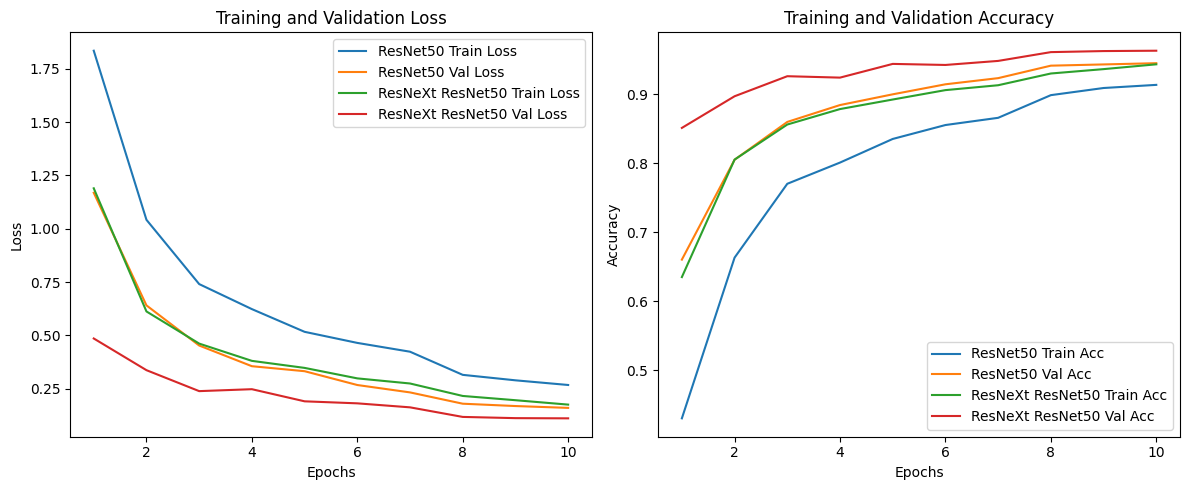

In [32]:
def plot_history(history_resnet, history_resnext, num_epochs, save_path=None):
    epochs = range(1, num_epochs + 1)

    # Plot Loss
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, history_resnet['train_loss'], label='ResNet50 Train Loss')
    plt.plot(epochs, history_resnet['val_loss'], label='ResNet50 Val Loss')
    plt.plot(epochs, history_resnext['train_loss'], label='ResNeXt ResNet50 Train Loss')
    plt.plot(epochs, history_resnext['val_loss'], label='ResNeXt ResNet50 Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history_resnet['train_acc'], label='ResNet50 Train Acc')
    plt.plot(epochs, history_resnet['val_acc'], label='ResNet50 Val Acc')
    plt.plot(epochs, history_resnext['train_acc'], label='ResNeXt ResNet50 Train Acc')
    plt.plot(epochs, history_resnext['val_acc'], label='ResNeXt ResNet50 Val Acc')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path)
        print(f"Training history plot saved to {save_path}")

    plt.show()

# Plot the training histories
plot_history(history_resnet50, history_resnet50_modified, num_epochs, '/data/cmpe258-sp24/017553289/cmpe258/Assignment1/runs/train/loss_acc_plot.pdf')

In [33]:
def summarize_results(history_resnet, history_resnext):
    best_val_acc_resnet = max(history_resnet['val_acc'])
    best_val_acc_resnext = max(history_resnext['val_acc'])

    print(f"Original ResNet50 Best Validation Accuracy: {best_val_acc_resnet:.4f}")
    print(f"Modified ResNeXt-based ResNet50 Best Validation Accuracy: {best_val_acc_resnext:.4f}")

    if best_val_acc_resnext > best_val_acc_resnet:
        print("The ResNeXt-based ResNet50 model outperformed the original ResNet50 model.")
    elif best_val_acc_resnext < best_val_acc_resnet:
        print("The original ResNet50 model outperformed the ResNeXt-based ResNet50 model.")
    else:
        print("Both models achieved the same best validation accuracy.")

summarize_results(history_resnet50, history_resnet50_modified)

Original ResNet50 Best Validation Accuracy: 0.9452
Modified ResNeXt-based ResNet50 Best Validation Accuracy: 0.9633
The ResNeXt-based ResNet50 model outperformed the original ResNet50 model.


Classification Report for Original ResNet50:
                  precision    recall  f1-score   support

           tench       0.98      0.97      0.98       387
English_springer       0.98      0.98      0.98       395
 cassette_player       0.94      0.94      0.94       357
       chain_saw       0.91      0.88      0.89       386
          church       0.97      0.97      0.97       409
     French_horn       0.94      0.94      0.94       394
   garbage_truck       0.92      0.96      0.94       389
        gas_pump       0.93      0.90      0.92       419
       golf_ball       0.96      0.96      0.96       399
       parachute       0.92      0.96      0.94       390

        accuracy                           0.95      3925
       macro avg       0.95      0.95      0.95      3925
    weighted avg       0.95      0.95      0.95      3925

Classification Report for Modified ResNeXt-based ResNet50:
                  precision    recall  f1-score   support

           tench      

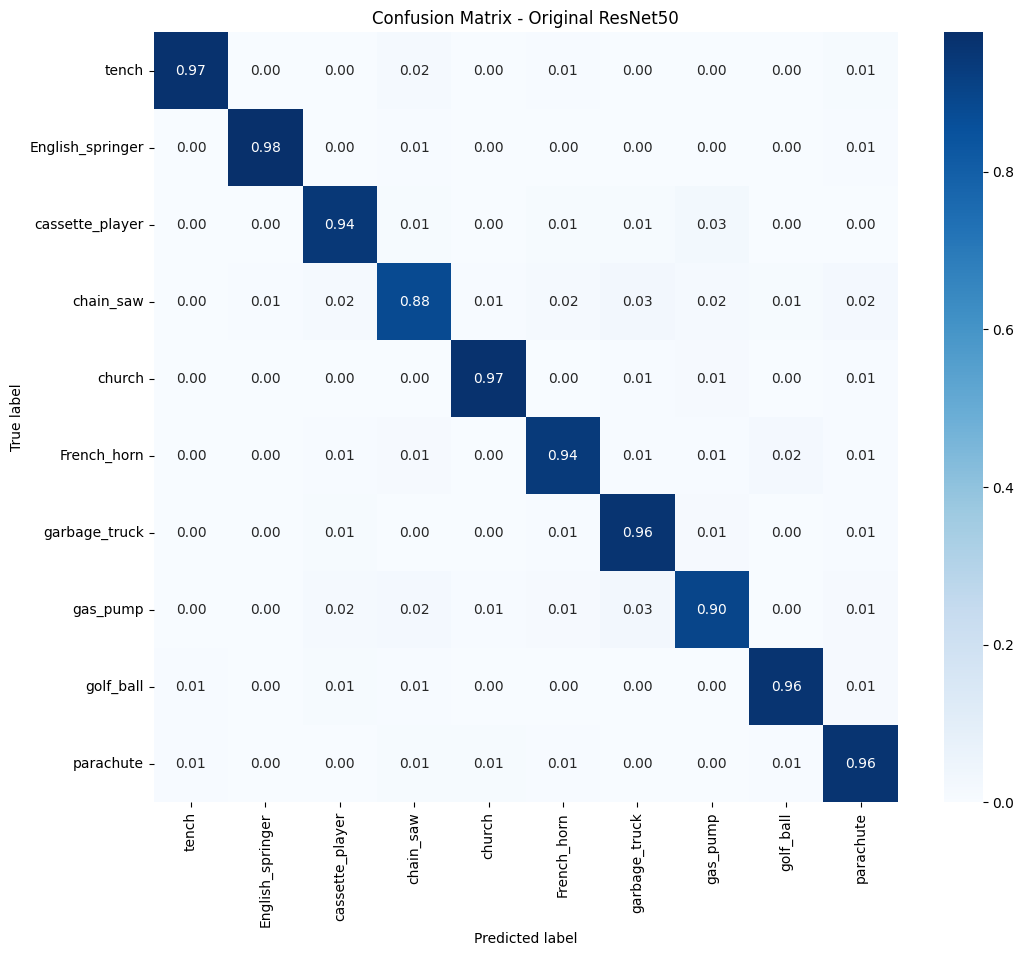

Confusion matrix plot saved to /data/cmpe258-sp24/017553289/cmpe258/Assignment1/runs/train/confusion_matrix_ResNet50_modified.png


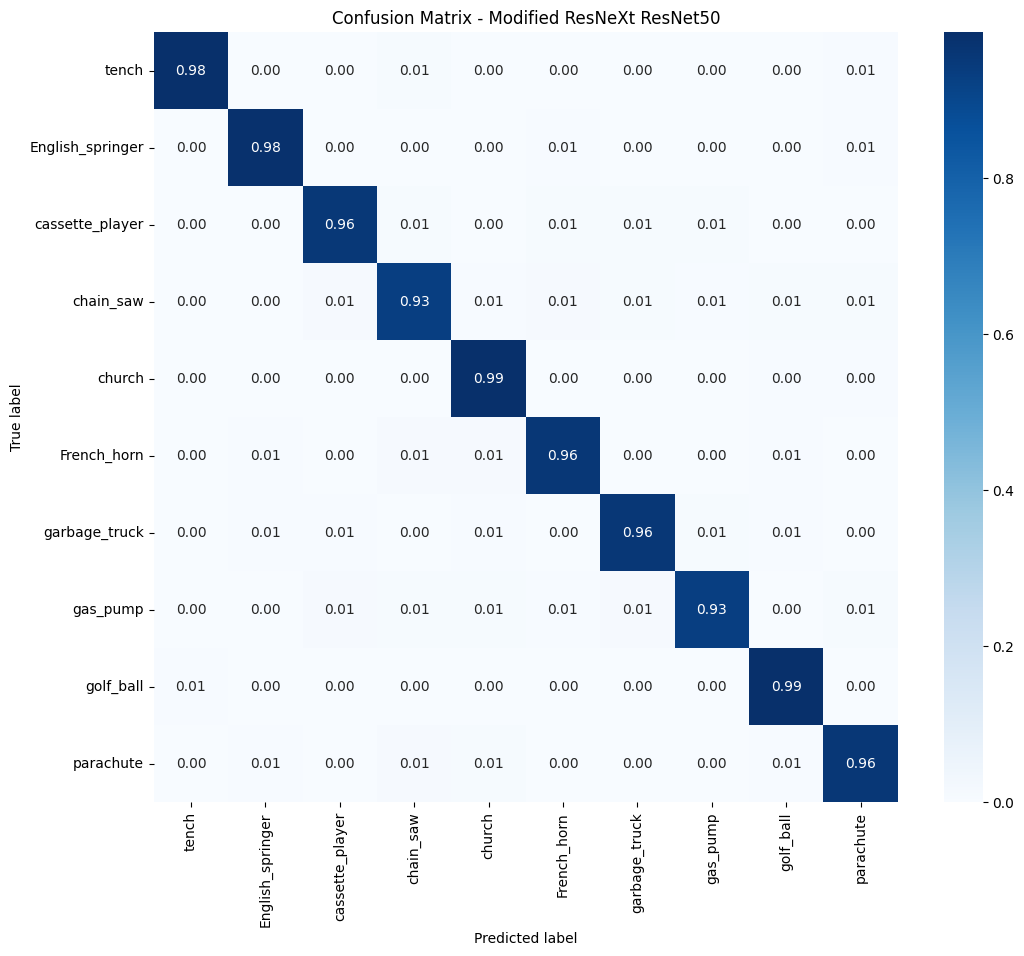

In [34]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np

def evaluate_model(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for imgs, targets in dataloader:
            imgs = imgs.to(device)
            targets = targets.to(device)

            outputs = model(imgs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(targets.cpu().numpy())

    return all_preds, all_labels

# Evaluate both models
preds_resnet50, labels_resnet50 = evaluate_model(model_resnet50_trained, val_loader)
preds_resnet50_modified, labels_resnet50_modified = evaluate_model(model_resnet50_modified_trained, val_loader)

def className2desc(class_names, id_to_desc):
    return [id_to_desc[name] for name in class_names]

# Convert class_name to real name
desc_names = className2desc(class_names, id_to_desc)
# Generate classification reports
print("Classification Report for Original ResNet50:")
print(classification_report(labels_resnet50, preds_resnet50, target_names=desc_names))

print("Classification Report for Modified ResNeXt-based ResNet50:")
print(classification_report(labels_resnet50_modified, preds_resnet50_modified, target_names=desc_names))

# Generate confusion matrices
def plot_confusion_matrix(labels, preds, desc_names, title, save_path=None):
    cm = confusion_matrix(labels, preds)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(12, 10))
    sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap='Blues',
                xticklabels=desc_names, yticklabels=desc_names)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title(title)

    if save_path:
        plt.savefig(save_path)
        print(f"Confusion matrix plot saved to {save_path}")

    plt.show()

# Plot confusion matrices
plot_confusion_matrix(labels_resnet50, preds_resnet50, desc_names, "Confusion Matrix - Original ResNet50", '/data/cmpe258-sp24/017553289/cmpe258/Assignment1/runs/train/confusion_matrix_ResNet50.pdf')
plot_confusion_matrix(labels_resnet50_modified, preds_resnet50_modified, desc_names, "Confusion Matrix - Modified ResNeXt ResNet50", '/data/cmpe258-sp24/017553289/cmpe258/Assignment1/runs/train/confusion_matrix_ResNet50_modified.pdf')

### Expeirment 2

In [32]:
# Training both models
num_epochs = 10

# Train original ResNet50
print("Training Original ResNet50...")
model_resnet50_trained, history_resnet50 = train_model(
    model_resnet50,
    criterion,
    optimizer_resnet50,
    scheduler_resnet50,
    'ResNet50',
    wr_resnet,
    num_epochs=num_epochs
)

# Train modified ResNeXt-based ResNet50
print("\nTraining Modified ResNeXt-based ResNet50...")
model_resnet50_modified_trained, history_resnet50_modified = train_model(
    model_resnet50_modified,
    criterion,
    optimizer_resnet50_modified,
    scheduler_resnet50_modified,
    'ResNet50_modified',
    wr_resnet_modified,
    num_epochs=num_epochs
)

%load_ext tensorboard
%tensorboard --logdir=runs

Training Original ResNet50...
Epoch 1/10
----------
Epoch [1/10], Batch [0], Training Loss: 7.2405, 
Epoch [1/10], Batch [50], Training Loss: 2.4347, 
Epoch [1/10], Batch [100], Training Loss: 2.1221, 
Epoch [1/10], Batch [150], Training Loss: 2.3546, 
Epoch [1/10], Batch [200], Training Loss: 1.8140, 
Epoch [1/10], Batch [250], Training Loss: 2.3895, 
Epoch [1/10], Batch [300], Training Loss: 2.0394, 
Epoch [1/10], Batch [350], Training Loss: 2.2521, 
Epoch [1/10], Batch [400], Training Loss: 1.1858, 
Epoch [1/10], Batch [450], Training Loss: 1.5141, 
Epoch [1/10], Batch [500], Training Loss: 2.3320, 
Epoch [1/10], Batch [550], Training Loss: 1.2064, 
FC layer weights have been updated.
Train Loss: 1.9849 Acc: 0.3445
Val Loss: 1.3376 Acc: 0.5697
Saved checkpoint: /data/cmpe258-sp24/017553289/cmpe258/Assignment1/runs/train/ResNet50_best_acc_1.pt
New best Accuracy: 0.5697. Saved best checkpoint.
Epoch 2/10
----------
Epoch [2/10], Batch [0], Training Loss: 2.4807, 
Epoch [2/10], Batch [

Reusing TensorBoard on port 6006 (pid 192832), started 11:04:37 ago. (Use '!kill 192832' to kill it.)

# Visualization experiment2

In [33]:
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('pdf', 'svg')

Training history plot saved to /data/cmpe258-sp24/017553289/cmpe258/Assignment1/runs/train/loss_acc_plot.pdf


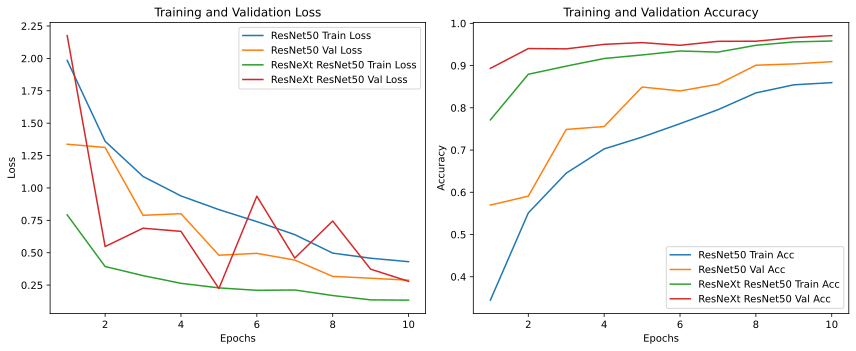

In [34]:
def plot_history(history_resnet, history_resnext, num_epochs, save_path=None):
    epochs = range(1, num_epochs + 1)

    # Plot Loss
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, history_resnet['train_loss'], label='ResNet50 Train Loss')
    plt.plot(epochs, history_resnet['val_loss'], label='ResNet50 Val Loss')
    plt.plot(epochs, history_resnext['train_loss'], label='ResNeXt ResNet50 Train Loss')
    plt.plot(epochs, history_resnext['val_loss'], label='ResNeXt ResNet50 Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history_resnet['train_acc'], label='ResNet50 Train Acc')
    plt.plot(epochs, history_resnet['val_acc'], label='ResNet50 Val Acc')
    plt.plot(epochs, history_resnext['train_acc'], label='ResNeXt ResNet50 Train Acc')
    plt.plot(epochs, history_resnext['val_acc'], label='ResNeXt ResNet50 Val Acc')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path)
        print(f"Training history plot saved to {save_path}")

    plt.show()

# Plot the training histories
plot_history(history_resnet50, history_resnet50_modified, num_epochs, '/data/cmpe258-sp24/017553289/cmpe258/Assignment1/runs/train/loss_acc_plot.pdf')

In [35]:
def summarize_results(history_resnet, history_resnext):
    best_val_acc_resnet = max(history_resnet['val_acc'])
    best_val_acc_resnext = max(history_resnext['val_acc'])

    print(f"Original ResNet50 Best Validation Accuracy: {best_val_acc_resnet:.4f}")
    print(f"Modified ResNeXt-based ResNet50 Best Validation Accuracy: {best_val_acc_resnext:.4f}")

    if best_val_acc_resnext > best_val_acc_resnet:
        print("The ResNeXt-based ResNet50 model outperformed the original ResNet50 model.")
    elif best_val_acc_resnext < best_val_acc_resnet:
        print("The original ResNet50 model outperformed the ResNeXt-based ResNet50 model.")
    else:
        print("Both models achieved the same best validation accuracy.")

summarize_results(history_resnet50, history_resnet50_modified)

Original ResNet50 Best Validation Accuracy: 0.9093
Modified ResNeXt-based ResNet50 Best Validation Accuracy: 0.9710
The ResNeXt-based ResNet50 model outperformed the original ResNet50 model.


Classification Report for Original ResNet50:
                  precision    recall  f1-score   support

           tench       0.94      0.95      0.94       387
English_springer       0.94      0.95      0.94       395
 cassette_player       0.89      0.90      0.89       357
       chain_saw       0.85      0.84      0.84       386
          church       0.91      0.95      0.93       409
     French_horn       0.93      0.90      0.91       394
   garbage_truck       0.90      0.92      0.91       389
        gas_pump       0.88      0.84      0.86       419
       golf_ball       0.95      0.92      0.93       399
       parachute       0.91      0.93      0.92       390

        accuracy                           0.91      3925
       macro avg       0.91      0.91      0.91      3925
    weighted avg       0.91      0.91      0.91      3925

Classification Report for Modified ResNeXt-based ResNet50:
                  precision    recall  f1-score   support

           tench      

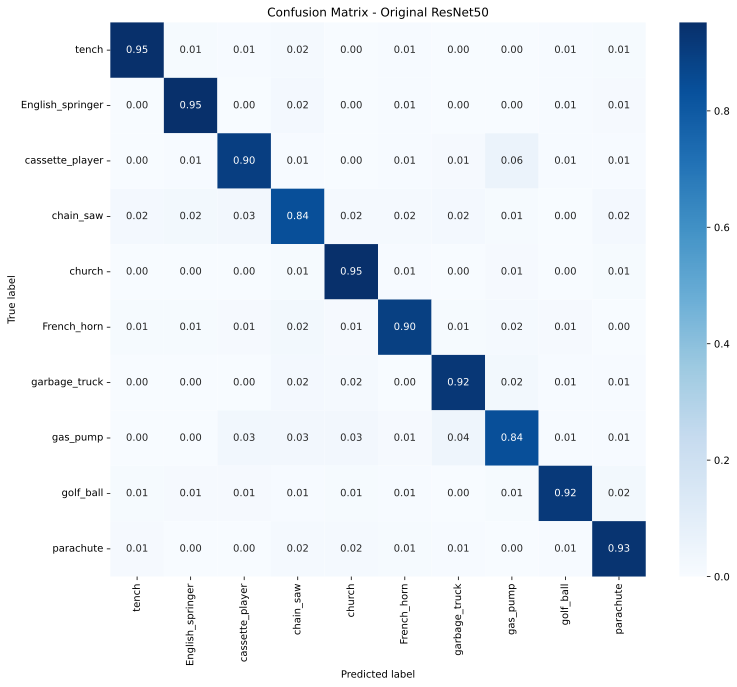

Confusion matrix plot saved to /data/cmpe258-sp24/017553289/cmpe258/Assignment1/runs/train/confusion_matrix_ResNet50_modified.pdf


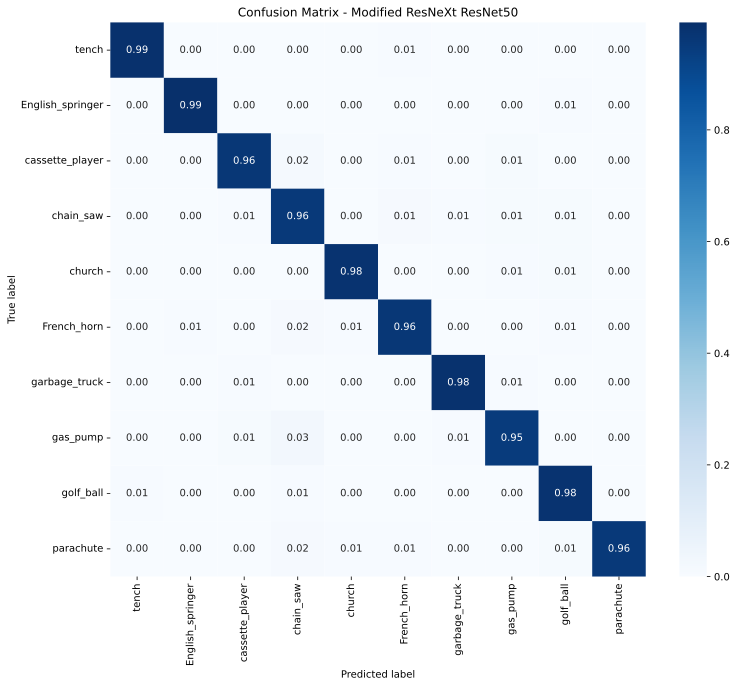

In [36]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np

def evaluate_model(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for imgs, targets in dataloader:
            imgs = imgs.to(device)
            targets = targets.to(device)

            outputs = model(imgs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(targets.cpu().numpy())

    return all_preds, all_labels

# Evaluate both models
preds_resnet50, labels_resnet50 = evaluate_model(model_resnet50_trained, val_loader)
preds_resnet50_modified, labels_resnet50_modified = evaluate_model(model_resnet50_modified_trained, val_loader)

def className2desc(class_names, id_to_desc):
    return [id_to_desc[name] for name in class_names]

# Convert class_name to real name
desc_names = className2desc(class_names, id_to_desc)
# Generate classification reports
print("Classification Report for Original ResNet50:")
print(classification_report(labels_resnet50, preds_resnet50, target_names=desc_names))

print("Classification Report for Modified ResNeXt-based ResNet50:")
print(classification_report(labels_resnet50_modified, preds_resnet50_modified, target_names=desc_names))

# Generate confusion matrices
def plot_confusion_matrix(labels, preds, desc_names, title, save_path=None):
    cm = confusion_matrix(labels, preds)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(12, 10))
    sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap='Blues',
                xticklabels=desc_names, yticklabels=desc_names)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title(title)

    if save_path:
        plt.savefig(save_path)
        print(f"Confusion matrix plot saved to {save_path}")

    plt.show()

# Plot confusion matrices
plot_confusion_matrix(labels_resnet50, preds_resnet50, desc_names, "Confusion Matrix - Original ResNet50", '/data/cmpe258-sp24/017553289/cmpe258/Assignment1/runs/train/confusion_matrix_ResNet50.pdf')
plot_confusion_matrix(labels_resnet50_modified, preds_resnet50_modified, desc_names, "Confusion Matrix - Modified ResNeXt ResNet50", '/data/cmpe258-sp24/017553289/cmpe258/Assignment1/runs/train/confusion_matrix_ResNet50_modified.pdf')

# Model Export to Torchscript

In [35]:
model_resnet50.eval()
model_resnet50_modified.eval()
scripted_model_resnet50 = torch.jit.script(model_resnet50)
scripted_model_resnet50_modified = torch.jit.script(model_resnet50_modified)

In [36]:
scripted_model_resnet50

RecursiveScriptModule(
  original_name=ResNet
  (conv1): RecursiveScriptModule(original_name=Conv2d)
  (bn1): RecursiveScriptModule(original_name=BatchNorm2d)
  (relu): RecursiveScriptModule(original_name=ReLU)
  (maxpool): RecursiveScriptModule(original_name=MaxPool2d)
  (layer1): RecursiveScriptModule(
    original_name=Sequential
    (0): RecursiveScriptModule(
      original_name=Bottleneck
      (conv1): RecursiveScriptModule(original_name=Conv2d)
      (bn1): RecursiveScriptModule(original_name=BatchNorm2d)
      (conv2): RecursiveScriptModule(original_name=Conv2d)
      (bn2): RecursiveScriptModule(original_name=BatchNorm2d)
      (conv3): RecursiveScriptModule(original_name=Conv2d)
      (bn3): RecursiveScriptModule(original_name=BatchNorm2d)
      (relu): RecursiveScriptModule(original_name=ReLU)
      (downsample): RecursiveScriptModule(
        original_name=Sequential
        (0): RecursiveScriptModule(original_name=Conv2d)
        (1): RecursiveScriptModule(original_name=B

In [37]:
scripted_model_resnet50_modified

RecursiveScriptModule(
  original_name=ResNet
  (conv1): RecursiveScriptModule(original_name=Conv2d)
  (bn1): RecursiveScriptModule(original_name=BatchNorm2d)
  (relu): RecursiveScriptModule(original_name=ReLU)
  (maxpool): RecursiveScriptModule(original_name=MaxPool2d)
  (layer1): RecursiveScriptModule(
    original_name=Sequential
    (0): RecursiveScriptModule(
      original_name=ResNeXtBottleneck
      (conv1): RecursiveScriptModule(original_name=Conv2d)
      (bn1): RecursiveScriptModule(original_name=BatchNorm2d)
      (conv2): RecursiveScriptModule(original_name=Conv2d)
      (bn2): RecursiveScriptModule(original_name=BatchNorm2d)
      (conv3): RecursiveScriptModule(original_name=Conv2d)
      (bn3): RecursiveScriptModule(original_name=BatchNorm2d)
      (relu): RecursiveScriptModule(original_name=ReLU)
      (downsample): RecursiveScriptModule(
        original_name=Sequential
        (0): RecursiveScriptModule(original_name=Conv2d)
        (1): RecursiveScriptModule(original

In [38]:
scripted_model_resnet50.save('resnet50_scripted.pt')
scripted_model_resnet50_modified.save('resnet50_modified_scripted.pt')

In [ ]:
# Load scripted model
scripted_model_resnet50 = torch.jit.load('resnet50_scripted.pt')
scripted_model_resnet50_modified = torch.jit.load('resnet50_modified_scripted.pt')

In [39]:
scripted_model_resnet50_modified.to(device)
scripted_model_resnet50_modified.eval()

RecursiveScriptModule(
  original_name=ResNet
  (conv1): RecursiveScriptModule(original_name=Conv2d)
  (bn1): RecursiveScriptModule(original_name=BatchNorm2d)
  (relu): RecursiveScriptModule(original_name=ReLU)
  (maxpool): RecursiveScriptModule(original_name=MaxPool2d)
  (layer1): RecursiveScriptModule(
    original_name=Sequential
    (0): RecursiveScriptModule(
      original_name=ResNeXtBottleneck
      (conv1): RecursiveScriptModule(original_name=Conv2d)
      (bn1): RecursiveScriptModule(original_name=BatchNorm2d)
      (conv2): RecursiveScriptModule(original_name=Conv2d)
      (bn2): RecursiveScriptModule(original_name=BatchNorm2d)
      (conv3): RecursiveScriptModule(original_name=Conv2d)
      (bn3): RecursiveScriptModule(original_name=BatchNorm2d)
      (relu): RecursiveScriptModule(original_name=ReLU)
      (downsample): RecursiveScriptModule(
        original_name=Sequential
        (0): RecursiveScriptModule(original_name=Conv2d)
        (1): RecursiveScriptModule(original

In [ ]:
model_resnet50_modified.eval()

In [43]:
# Compare Output with sample data
# This proves that exported model works correctly
sample_input, sample_target = next(iter(val_loader))
sample_input = sample_input.to(device)
sample_target = sample_target.to(device)

with torch.no_grad():
    original_output = model_resnet50_modified(sample_input)

with torch.no_grad():
    scripted_output = scripted_model_resnet50_modified(sample_input)


# Compare outputs
difference = torch.abs(original_output - scripted_output).max().item()
print(f"Max difference between original and traced model outputs: {difference}")

Max difference between original and traced model outputs: 0.0


In [56]:
!cd ResNet50_inference

In [60]:
!./ResNet50_inference/build/inference ./ResNet50_inference/resnet50_modified_scripted.pt

error loading the model


In [25]:
! ./ResNet50_inference/build/inference ./ResNet50_inference/resnet50_modified_scripted.pt

CUDA not available. Using CPU for inference.
-0.8277 -0.7303 -0.2075  0.1377 -0.6530
[ CPUFloatType{1,5} ]
ok


# Model Exporting to ONNX

In [29]:
# Load best accuracy model
pretrained = torch.load('/data/cmpe258-sp24/017553289/cmpe258/Assignment1/runs/train/experiment2/ResNet50_modified_best_acc_10.pt', map_location=torch.device('cpu'))
# pretrained = torch.load('/data/cmpe258-sp24/017553289/cmpe258/Assignment1/runs/train/experiment2/ResNet50_modified_best_acc_10.pt')
model_resnet50_modified.load_state_dict(pretrained['model_state_dict'])

/tmp/ipykernel_78869/143386232.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained = torch.load('/data/cmpe258-sp24/017553289/cmpe258/Assignment1/runs/train/exper

<All keys matched successfully>

In [30]:
model_resnet50_modified.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): ResNeXtBottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_

In [32]:
import numpy as np    # we're going to use numpy to process input and output data
import onnxruntime    # to inference ONNX models, we use the ONNX Runtime
import onnx
from onnx import numpy_helper
import matplotlib.pyplot as plt

In [33]:
image_height = 224
image_width = 224
x = torch.randn(1, 3, image_height, image_width, requires_grad=True)
model_resnet50_modified.eval()
torch.onnx.export(model_resnet50_modified,                     # model being run
                  x,                            # model input (or a tuple for multiple inputs)
                  "resnet50_modified.onnx",              # where to save the model (can be a file or file-like object)
                  export_params=True,           # store the trained parameter weights inside the model file
                  opset_version=12,             # the ONNX version to export the model to
                  do_constant_folding=True,     # whether to execute constant folding for optimization
                  input_names = ['input'],      # the model's input names
                  output_names = ['output'])    # the model's output names

In [34]:
onnx_model = onnx.load("resnet50_modified.onnx")

In [38]:
onnx.checker.check_model(onnx_model)

In [35]:
session_fp32 = onnxruntime.InferenceSession("resnet50_modified.onnx", providers=['CPUExecutionProvider'])
# session_cuda = onnxruntime.InferenceSession("resnet50_modified.onnx", providers=['CUDAExecutionProvider'])

In [63]:
# import time
# def run_sample(session, categories, inputs):
#     latency = []
#     start = time.time()
#     # input_arr = inputs.cpu().detach().numpy()
#     input_arr = inputs[0].cpu().detach().numpy()
#     ort_outputs = session.run([], {'input':input_arr})[0]
#     latency.append(time.time() - start)
#     output = ort_outputs.flatten()
#     output = softmax(output) # this is optional
#     top5_catid = np.argsort(-output)[:5]
#     for catid in top5_catid:
#         print(categories[catid], output[catid])
#     return ort_outputs, latency

In [38]:
import onnxruntime as ort
import numpy as np
from sklearn.metrics import classification_report, accuracy_score

# Load the ONNX model
ort_session = ort.InferenceSession("resnet50_modified.onnx", providers=['CPUExecutionProvider'])

def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

def infer_onnx(ort_session, input_tensor):
    ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(input_tensor)}
    ort_outs = ort_session.run(None, ort_inputs)
    return ort_outs[0]

# Evaluation function
def evaluate_onnx_model(ort_session, dataloader, device):
    all_preds = []
    all_labels = []
    
    for idx, (batch) in enumerate(dataloader):
        if idx == 5:
            break
        inputs, labels = batch
    # for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        outputs = infer_onnx(ort_session, inputs)
        preds = np.argmax(outputs, axis=1)
        
        all_preds.extend(preds)
        all_labels.extend(labels.cpu().numpy())

    # inputs, labels = dataloader
    # inputs = inputs.to(device)
    # labels = labels.to(device)
    
    # outputs = infer_onnx(ort_session, inputs)
    # preds = np.argmax(outputs, axis=1)
    
    # all_preds.extend(preds)
    # all_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    report = classification_report(all_labels, all_preds, target_names=class_names)
    
    return acc, report, all_labels, all_preds

# Evaluate
# onnx_accuracy, onnx_report, onnx_true, onnx_pred = evaluate_onnx_model(ort_session, val_loader, device)
# print(f"ONNX Runtime Model Accuracy: {onnx_accuracy * 100:.2f}%")
# print("Classification Report for ONNX Runtime Model:")
# print(onnx_report)

In [50]:
# Latency check for one batch, size of 16

import time

def measure_latency_onnx(ort_session, dataloader, device, num_batches=100):
    total_time = 0.0
    batch_count = 0
    
    # Warm-up
    for _ in range(10):
        inputs, _ = next(iter(dataloader))
        inputs = inputs.to(device)
        _ = infer_onnx(ort_session, inputs)
    
    # Measure latency
    for idx, batch in enumerate(dataloader):
        inputs, _ = batch
        if batch_count >= num_batches:
            break
        
        inputs = inputs.to(device)
        
        start_time = time.time()
        _ = infer_onnx(ort_session, inputs)
        end_time = time.time()
        
        total_time += (end_time - start_time)
        batch_count += 1
        if idx == 0:
            break
    
    avg_latency_ms = (total_time / batch_count) * 1000  # milliseconds

    # for inputs, _ in dataloader:
    #     if batch_count >= num_batches:
    #         break
        
    #     inputs = inputs.to(device)
        
    #     start_time = time.time()
    #     _ = infer_onnx(ort_session, inputs)
    #     end_time = time.time()
        
    #     total_time += (end_time - start_time)
    #     batch_count += 1
    
    # avg_latency_ms = (total_time / batch_count) * 1000  # milliseconds
    return avg_latency_ms

# Measure latency for one image
batch_size=1
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=2)

onnx_avg_latency = measure_latency_onnx(ort_session, val_loader, device, num_batches=100)
print(f"Average Inference Latency for ONNX Runtime Model: {onnx_avg_latency:.2f} ms per image")

Average Inference Latency for ONNX Runtime Model: 37.35 ms per image


In [56]:
model_resnet50_modified.eval()
total_time = 0.0
with torch.no_grad():
    for idx, batch in enumerate(val_loader):
        imgs, targets = batch
        imgs = imgs.to(device)
        targets = targets.to(device)
        start_time = time.time()
        outputs = model_resnet50_modified(imgs)
        end_time = time.time() 
        total_time += (end_time - start_time)
        if idx == 0:
            break
avg_latency_ms = (total_time / 1) * 1000  # milliseconds
print(f"Average Inference Latency for Model without export: {avg_latency_ms:.2f} ms per image")
    

Average Inference Latency for Model without export: 141.98 ms per image


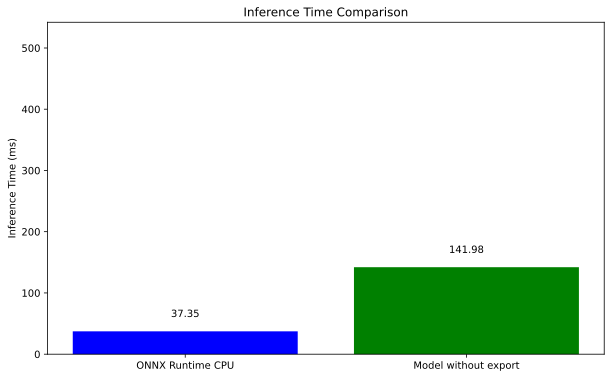

In [6]:
latencies = [37.35, 141.98]
# latencies.append(onnx_avg_latency)
# latencies.append(avg_latency_ms)
frameworks = ['ONNX Runtime CPU', 'Model without export']
colors = ['blue', 'green']
plt.figure(figsize=(10, 6))
plt.bar(frameworks, latencies, color=colors)

plt.title('Inference Time Comparison')
plt.ylabel('Inference Time (ms)')
plt.ylim(0, max(latencies) + 400)
for i, v in enumerate(latencies):
    plt.text(i, v + 20, f'{v:.2f}',
             ha='center', va='bottom')
plt.savefig('/data/cmpe258-sp24/017553289/cmpe258/Assignment1/ResNet50_inference/inference_time_comparison.png')
plt.show()